In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np

# Lendo os arquivos de resultados e fazendo castings

In [2]:
resultados =  pd.read_csv('../outputs_nostemmer/Resultados.csv', sep=';')
resultados_stemmer = pd.read_csv('../outputs_stemmer/Resultados.csv', sep=';')

In [3]:
resultados[['Rank', 'DocNumber', 'Score']] = resultados['List'].str.strip('[]').str.split(', ', expand=True)
resultados['QueryNumber'] = resultados['QueryNumber'].astype(int)
resultados['Rank'] = resultados['Rank'].astype(int)
resultados['DocNumber'] = resultados['DocNumber'].astype(int)
resultados['Score'] = resultados['Score'].astype(float)

In [4]:
resultados.columns

Index(['QueryNumber', 'List', 'Rank', 'DocNumber', 'Score'], dtype='object')

In [5]:
resultados_stemmer[['Rank', 'DocNumber', 'Score']] = resultados_stemmer['List'].str.strip('[]').str.split(', ', expand=True)
resultados_stemmer['Rank'] = resultados_stemmer['Rank'].astype(int)
resultados_stemmer['DocNumber'] = resultados_stemmer['DocNumber'].astype(int)
resultados_stemmer['Score'] = resultados_stemmer['Score'].astype(float)

In [6]:
esperados = pd.read_csv('../outputs_nostemmer/Esperados.csv', sep=';')
esperados['QueryNumber'] = esperados['QueryNumber'].astype(int)
esperados['DocNumber'] = esperados['DocNumber'].astype(int)
esperados['DocVotes'] = esperados['DocVotes'].astype(int)

# Gráfico de 11 pontos de precisão e recall

Para calcular precision e recall precisamos antes definir os valores para os verdadeiros positivos, falso positivo e falso negativo.
* Podemos definir o somatório de VP +FP como tudo aquilo que foi buscado pelo modelo, portanto Precisão = VP/Buscado
* Já VP + Fn pode ser difinido como o conjunto de resultados esperados, portanto Recall = VP/Esperado
* Por fim, VP isoladamente pode ser dado como a interseçao entre o esperado e o obtido VP = Buscado intersec Esperado

Calcularemos 11 pontos de precision e recall para cada query e em seguida faremos a média dos valores

In [33]:
def curva_precision_recall_11(resultados, esperados, stemmer):
    buscas_recall = []
    busca_precisions = []
    conjunto_buscas = set(esperados['QueryNumber'].to_list())
    for busca in conjunto_buscas:
        esperados_busca = esperados.loc[esperados['QueryNumber'] == busca, 'DocNumber'].to_list()
        resultados_busca = resultados.loc[resultados['QueryNumber'] == busca, 'DocNumber'].to_list()
        recall = []
        precision = []
        passo = round(len(resultados_busca)/11)
        for ponto in range(11):
            buscados_ponto = resultados_busca[:(ponto+1)*passo]
            vp = len(set(esperados_busca).intersection(buscados_ponto))
            precision.append(vp/len(buscados_ponto))
            recall.append(vp/len(esperados_busca))
        buscas_recall.append(recall)
        busca_precisions.append(precision)
    media_precision = np.mean(np.array(busca_precisions), axis=0)
    media_recall = np.mean(np.array(buscas_recall), axis=0)
    
    if stemmer:
        figure_path = '../avalia/11_precisao_recall_stemmer.pdf'
        csv_path = '../avalia/11_precisao_recall_stemmer.csv'
    else:
        figure_path = '../avalia/11_precisao_recall_nostemmer.pdf'
        csv_path = '../avalia/11_precisao_recall_nostemmer.csv'
    
    # Plotar o gráfico Precision-Recall
    plt.plot(media_recall, media_precision, marker='o', label='Precision-Recall Curve')

    # Configurações do gráfico
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.savefig(figure_path)
    # Exibir o gráfico
    plt.show()
    precision_recall_df = pd.DataFrame(np.array([media_precision, media_recall]).T, columns=["Precision", "Recall"])
    precision_recall_df.to_csv(csv_path, sep=";", index=False)

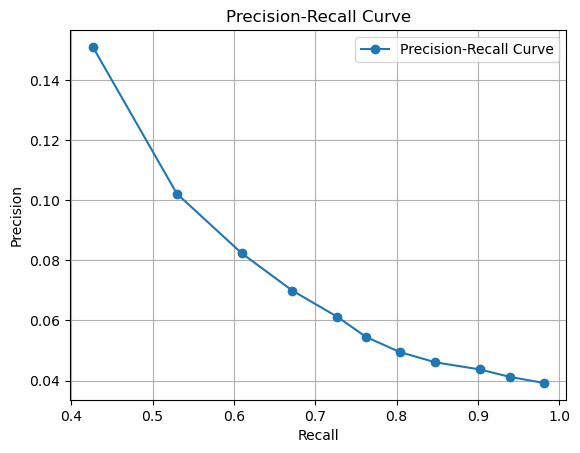

In [34]:
curva_precision_recall_11(resultados_stemmer, esperados, True)

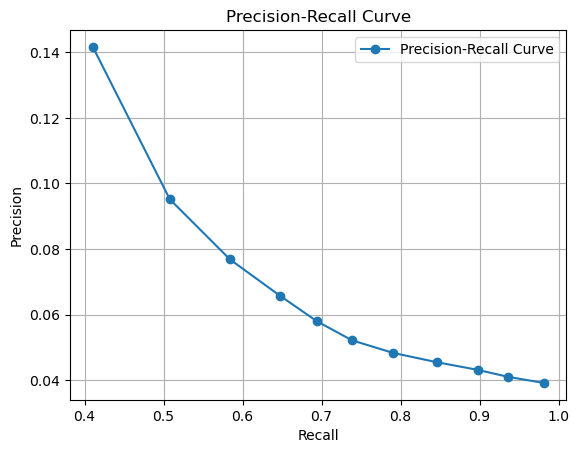

In [35]:
curva_precision_recall_11(resultados, esperados, False)

# F1 

In [7]:
def calculo_f1_score(resultados, esperados):
    buscas_recall = []
    busca_precisions = []
    conjunto_buscas = set(esperados['QueryNumber'].to_list())
    for busca in conjunto_buscas:
        esperados_busca = esperados.loc[esperados['QueryNumber'] == busca, 'DocNumber'].to_list()
        resultados_busca = resultados.loc[resultados['QueryNumber'] == busca, 'DocNumber'].to_list()
        recall = []
        precision = []
        vp = len(set(esperados_busca).intersection(resultados_busca))
        precision.append(vp/len(resultados_busca))
        recall.append(vp/len(esperados_busca))
        buscas_recall.append(recall)
        busca_precisions.append(precision)
    media_precision = np.mean(np.array(busca_precisions), axis=0)
    media_recall = np.mean(np.array(buscas_recall), axis=0)
    f1 = (2 * media_precision * media_recall)/(media_precision + media_recall)
    return f1